In [1]:
import requests
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from power.ml_ops.data import get_pv_data, clean_pv_data
from power.ml_ops.model import model_yesterday
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

## Get and preprocess data

In [2]:
data = get_pv_data()
clean_data =clean_pv_data(data)

# data loaded
# data cleaned


In [3]:
n_years = 5
reduced_idx = 365 * 24 * n_years

df = clean_data.iloc[-reduced_idx:,:].reset_index()
df.set_index('utc_time', inplace=True)

df.drop(columns=['index', 'local_time'], inplace=True)

In [4]:
def compress(df, **kwargs):
    """    Reduces size of dataframe by downcasting numerical columns    """
    input_size = df.memory_usage(index=True).sum()/ 1024
    print("new dataframe size: ", round(input_size,2), 'kB')

    in_size = df.memory_usage(index=True).sum()
    for type in ["float", "integer"]:
        l_cols = list(df.select_dtypes(include=type))
        for col in l_cols:
            df[col] = pd.to_numeric(df[col], downcast=type)
    out_size = df.memory_usage(index=True).sum()
    ratio = (1 - round(out_size / in_size, 2)) * 100

    print("optimized size by {} %".format(round(ratio,2)))
    print("new dataframe size: ", round(out_size / 1024,2), " kB")

    return df

compress(df)

new dataframe size:  684.38 kB
optimized size by 25.0 %
new dataframe size:  513.28  kB


,electricity
utc_time,
2018-01-02 00:00:00+00:00,0.0
2018-01-02 01:00:00+00:00,0.0
2018-01-02 02:00:00+00:00,0.0
2018-01-02 03:00:00+00:00,0.0
2018-01-02 04:00:00+00:00,0.0
...,...
2022-12-31 19:00:00+00:00,0.0
2022-12-31 20:00:00+00:00,0.0
2022-12-31 21:00:00+00:00,0.0


## Data decompostion

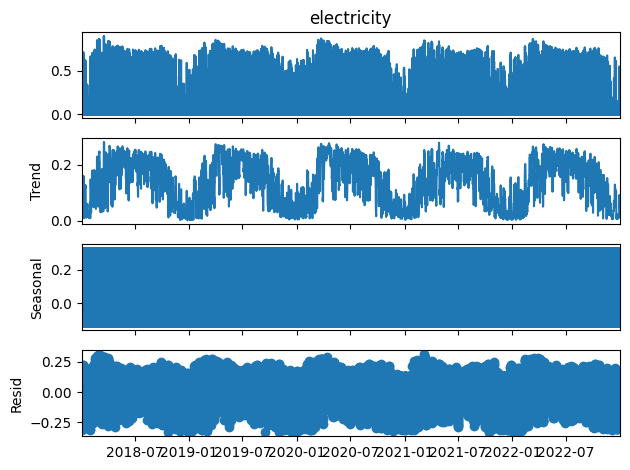

In [5]:
# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_add = seasonal_decompose(df['electricity'], model='additive')
result_add.plot();

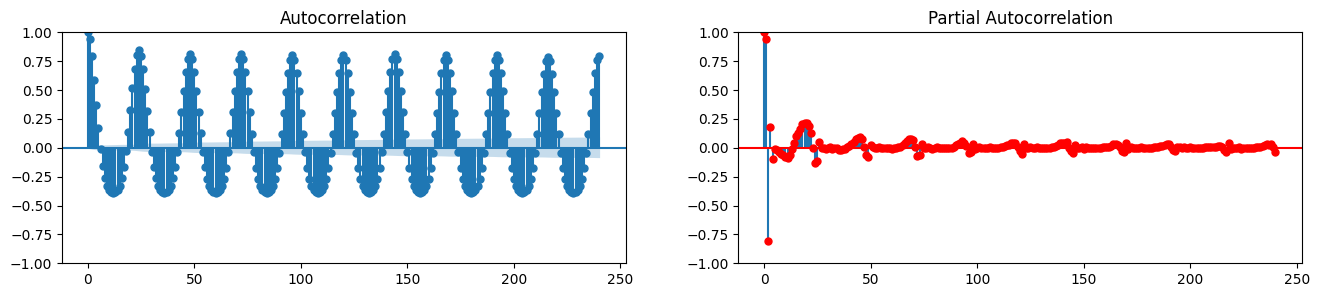

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1,2, figsize=(16,3))

plot_acf(df.electricity, lags=240, ax=axes[0]);
plot_pacf(df.electricity, lags=240, ax=axes[1], color='r');

## Check how many orders of differencing to apply

In [7]:
from pmdarima.arima.utils import ndiffs
ndiffs(df['electricity'])

1

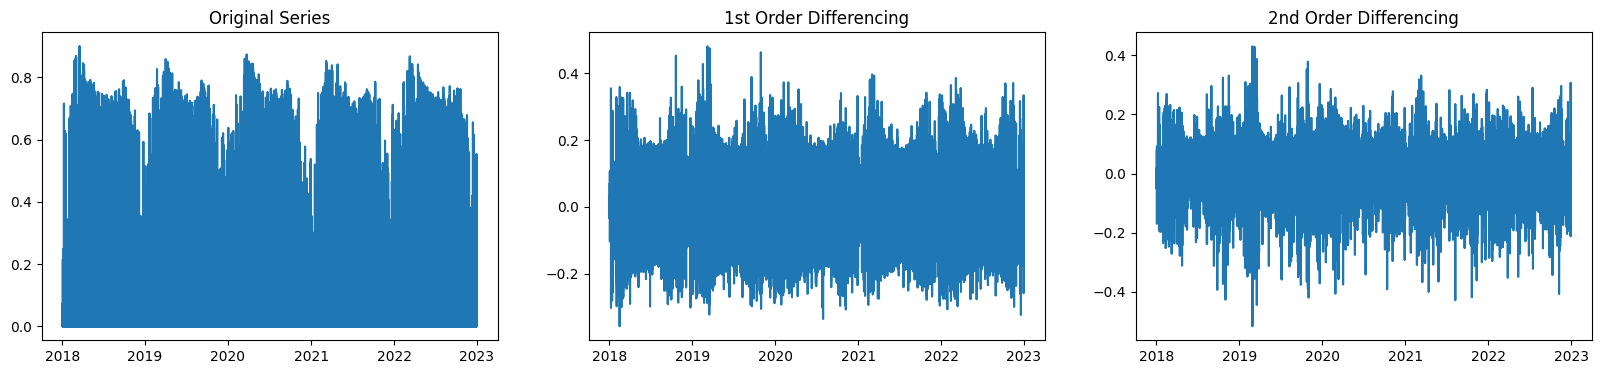

In [8]:
zero_diff = df.electricity
first_order_diff = df.electricity.diff()
second_order_diff = df.electricity.diff().diff()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
ax1.plot(zero_diff); ax1.set_title('Original Series')
ax2.plot(first_order_diff); ax2.set_title('1st Order Differencing')
ax3.plot(second_order_diff); ax3.set_title('2nd Order Differencing');

## Let's process the data and do ARIMA

(18048.0, 19205.0)

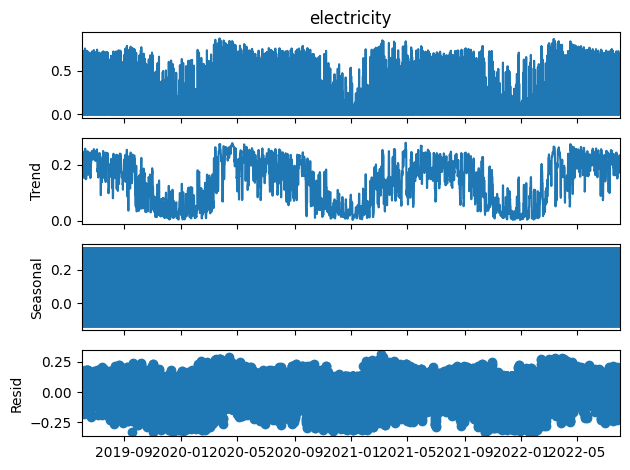

In [10]:
result_add.plot();
plt.xlim([datetime.date(2019, 6, 1), datetime.date(2022, 8, 1)])
